In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import glob
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.preprocess import read_normalize
from model.seg_model.model_scales_gate import unet_scales_gate
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
# ---------- Data paths ----------- #
paths_as = sorted(glob.glob(config.dir_as + '/*pad*.tif'))
paths_des = sorted(glob.glob(config.dir_des+'/*pad*.tif'))
paths_truth = sorted(glob.glob(config.dir_truth+'/*pad*.tif'))
paths_patch_val = sorted(glob.glob(config.dir_patch_val+'/*'))
print(len(paths_as))
print(paths_as[0])


37
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_ascend/scene01_s1as_pad.tif


In [4]:
'''--------- data loading --------'''


'--------- data loading --------'

In [5]:
'''--------- data loading --------'''
val_ids = [0,4,8,12,16,20,24,28,32,36]
tra_ids = list(set([i for i in range(36)])-set((val_ids)))
### ------ 1. training data loading: from scenes path ----- ### 
### 1.1. training scenes selection (in the application, all scenes are used for training.)
tra_scenes, tra_truths = read_normalize(paths_as=paths_as, paths_des=paths_des, \
                      paths_truth=paths_truth, max_bands=config.s1_max, min_bands=config.s1_min)
# ### !!!!extract either ascending or descending image.
# tra_scene = [s[2:4] for s in tra_scenes]        ## [0:2] -> ascending; [2:4] -> descending

### 1.2. training data loading
tra_scenes = [tra_scenes[id] for id in tra_ids]    ## select the training scenes
tra_truths = [tra_truths[id] for id in tra_ids]
tra_dset = threads_scene_dset(scene_list = tra_scenes, \
                              truth_list = tra_truths, 
                              transforms=config.transforms_tra, 
                              num_thread=30)

### ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in paths_patch_val]
# !!!extract either ascending or descending image for validation
# for i in range(len(patch_list_val)):
#    for j in range(len(patch_list_val[0][0])):
      # patch_list_val[i][0][j] = patch_list_val[i][0][j][2:4]   ## [0:2] -> ascending; [2:4] -> descending
   #   patch_list_val[i][0][j][0:2] = 0   ## [0:2] is ascending; and [2:4] is descending

val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())


size of training data: 810
size of val data: 500


In [6]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16)


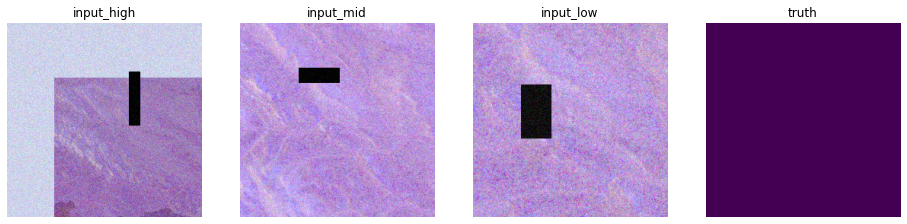

In [7]:
## check training data
for patches, truth in tra_loader:
    patches = patches
    break

patches_ = [patch.to('cpu').detach().numpy().transpose(0,2,3,1).astype(np.float32) for patch in patches]
patches_[0].shape
patches_list = [patches_[0][0],patches_[1][0],patches_[2][0], truth[0].numpy().transpose(1,2,0)]
patches_name = ['input_high','input_mid','input_low','truth']
clip_list = [1,1,1,1]
col_bands_list = [(0,1,2), (0,1,2), (0,1,2), (0,0,0)]
plt.figure(figsize=(16,5))
imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)


In [8]:
## ------------ Model ------------ ##
## -------- 3. gated multiple scales -------
model = unet_scales_gate(num_bands=4, num_classes=2, \
                    scale_high=2048, scale_mid=512, scale_low=256).to(device)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                          mode='min', factor=0.6, patience=10)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [10]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred,_,_ = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred,_,_ = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)
            # x_batch = x_batch[2]      # !!!note: x_batch[2] for single-scale model
            y_batch = config.label_smooth(y_batch)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                        optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)         # dynamic adjust learning rate using ReduceLROnPlateau
        # lr_scheduler.step()                 # dynamic adjust learning rate using StepLR

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = [batch.to(device).to(dtype=torch.float32) for batch in x_batch], y_batch.to(device)    
            # x_batch = x_batch[2]          #!!!note: x_batch[2] for single-scale model
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: Tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, Val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},Time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patches = [torch.unsqueeze(patch, 0).to(device).to(dtype=torch.float32) for patch in patches]
            truth = truth.to(device)
            # pred = model(patches[2])           # !!! note: x[2] for single-scale model
            pred, gate_mid, gate_high = model(patches)            
            patches = [patch[0].to('cpu').detach().numpy().transpose(1,2,0) for patch in patches]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            # gate_mid = gate_mid.to('cpu').detach().numpy()
            # gate_high = gate_high.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patches_list = patches + [truth, pred]
            # patches_list = patches + [gate_high[0][0], gate_mid[0][0]] + [truth, pred]
            # ---- plot result
            # print(f'gate_mid:{gate_mid[0,0,0,0]:.2f}, gate_high:{gate_high[0,0,0,0]:.2f}')
            plt.figure(figsize=(14,4))
            # patches_name = ['input_high','input_mid','input_low','gate_high','gate_mid','truth','pred']
            patches_name = ['input_high','input_mid','input_low','truth','pred']
            clip_list = [2,2,2,0,0]
            col_bands_list = [(0,1,0), (0,1,0), (0,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics
    

Ep1: Tra-> Loss:0.616,Oa:0.634,Miou:0.471, Val-> Loss:0.477,Oa:0.595,Miou:0.506,Time:11.7s
Ep2: Tra-> Loss:0.476,Oa:0.699,Miou:0.521, Val-> Loss:0.214,Oa:0.659,Miou:0.614,Time:11.7s
Ep3: Tra-> Loss:0.465,Oa:0.748,Miou:0.601, Val-> Loss:0.233,Oa:0.680,Miou:0.632,Time:11.9s
Ep4: Tra-> Loss:0.455,Oa:0.800,Miou:0.633, Val-> Loss:0.205,Oa:0.659,Miou:0.585,Time:11.6s
Ep5: Tra-> Loss:0.475,Oa:0.766,Miou:0.579, Val-> Loss:0.221,Oa:0.683,Miou:0.634,Time:11.7s
Ep6: Tra-> Loss:0.451,Oa:0.758,Miou:0.605, Val-> Loss:0.209,Oa:0.689,Miou:0.642,Time:11.8s
Ep7: Tra-> Loss:0.455,Oa:0.736,Miou:0.587, Val-> Loss:0.187,Oa:0.693,Miou:0.587,Time:11.8s
Ep8: Tra-> Loss:0.451,Oa:0.782,Miou:0.602, Val-> Loss:0.174,Oa:0.676,Miou:0.611,Time:11.4s
Ep9: Tra-> Loss:0.460,Oa:0.731,Miou:0.570, Val-> Loss:0.226,Oa:0.676,Miou:0.635,Time:11.7s
Ep10: Tra-> Loss:0.457,Oa:0.741,Miou:0.558, Val-> Loss:0.210,Oa:0.668,Miou:0.616,Time:11.3s


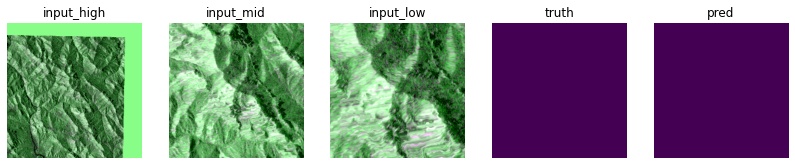

Ep11: Tra-> Loss:0.453,Oa:0.775,Miou:0.599, Val-> Loss:0.230,Oa:0.695,Miou:0.643,Time:11.3s
Ep12: Tra-> Loss:0.452,Oa:0.732,Miou:0.575, Val-> Loss:0.176,Oa:0.689,Miou:0.615,Time:11.5s
Ep13: Tra-> Loss:0.455,Oa:0.771,Miou:0.589, Val-> Loss:0.204,Oa:0.673,Miou:0.613,Time:11.6s
Ep14: Tra-> Loss:0.470,Oa:0.758,Miou:0.556, Val-> Loss:0.234,Oa:0.693,Miou:0.601,Time:11.7s
Ep15: Tra-> Loss:0.466,Oa:0.792,Miou:0.584, Val-> Loss:0.196,Oa:0.704,Miou:0.616,Time:11.5s
Ep16: Tra-> Loss:0.441,Oa:0.766,Miou:0.586, Val-> Loss:0.168,Oa:0.686,Miou:0.596,Time:11.7s
Ep17: Tra-> Loss:0.454,Oa:0.785,Miou:0.583, Val-> Loss:0.169,Oa:0.705,Miou:0.583,Time:11.8s
Ep18: Tra-> Loss:0.464,Oa:0.746,Miou:0.566, Val-> Loss:0.254,Oa:0.669,Miou:0.606,Time:11.9s
Ep19: Tra-> Loss:0.443,Oa:0.783,Miou:0.587, Val-> Loss:0.198,Oa:0.693,Miou:0.623,Time:11.2s
Ep20: Tra-> Loss:0.459,Oa:0.790,Miou:0.596, Val-> Loss:0.189,Oa:0.692,Miou:0.630,Time:11.8s


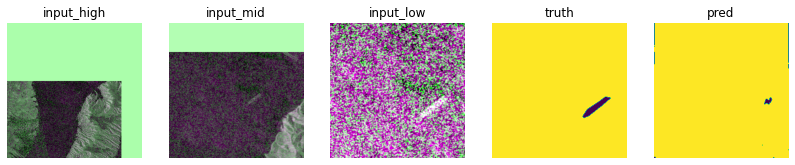

Ep21: Tra-> Loss:0.457,Oa:0.778,Miou:0.590, Val-> Loss:0.240,Oa:0.678,Miou:0.632,Time:11.5s
Ep22: Tra-> Loss:0.452,Oa:0.766,Miou:0.594, Val-> Loss:0.196,Oa:0.700,Miou:0.639,Time:11.3s
Ep23: Tra-> Loss:0.456,Oa:0.771,Miou:0.573, Val-> Loss:0.184,Oa:0.712,Miou:0.605,Time:11.8s
Ep24: Tra-> Loss:0.462,Oa:0.788,Miou:0.582, Val-> Loss:0.266,Oa:0.691,Miou:0.617,Time:12.1s
Ep25: Tra-> Loss:0.449,Oa:0.773,Miou:0.569, Val-> Loss:0.166,Oa:0.744,Miou:0.614,Time:11.7s
Ep26: Tra-> Loss:0.459,Oa:0.771,Miou:0.570, Val-> Loss:0.195,Oa:0.702,Miou:0.639,Time:11.9s
Ep27: Tra-> Loss:0.435,Oa:0.816,Miou:0.619, Val-> Loss:0.189,Oa:0.691,Miou:0.632,Time:11.6s
Ep28: Tra-> Loss:0.439,Oa:0.796,Miou:0.626, Val-> Loss:0.224,Oa:0.700,Miou:0.644,Time:11.6s
Ep29: Tra-> Loss:0.449,Oa:0.782,Miou:0.580, Val-> Loss:0.153,Oa:0.736,Miou:0.608,Time:11.7s
Ep30: Tra-> Loss:0.441,Oa:0.812,Miou:0.604, Val-> Loss:0.178,Oa:0.681,Miou:0.626,Time:11.2s


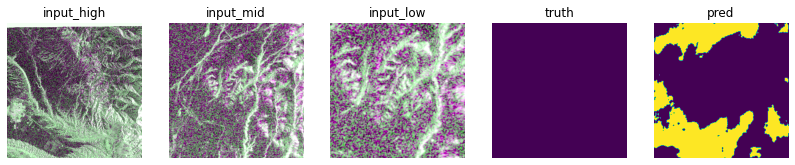

Ep31: Tra-> Loss:0.435,Oa:0.806,Miou:0.645, Val-> Loss:0.180,Oa:0.705,Miou:0.659,Time:11.3s
Ep32: Tra-> Loss:0.430,Oa:0.795,Miou:0.651, Val-> Loss:0.187,Oa:0.725,Miou:0.615,Time:11.6s
Ep33: Tra-> Loss:0.431,Oa:0.831,Miou:0.649, Val-> Loss:0.203,Oa:0.682,Miou:0.634,Time:11.5s
Ep34: Tra-> Loss:0.429,Oa:0.810,Miou:0.663, Val-> Loss:0.150,Oa:0.722,Miou:0.670,Time:11.6s
Ep35: Tra-> Loss:0.453,Oa:0.811,Miou:0.645, Val-> Loss:0.235,Oa:0.655,Miou:0.613,Time:11.5s
Ep36: Tra-> Loss:0.446,Oa:0.817,Miou:0.667, Val-> Loss:0.191,Oa:0.704,Miou:0.645,Time:11.8s
Ep37: Tra-> Loss:0.442,Oa:0.820,Miou:0.644, Val-> Loss:0.179,Oa:0.689,Miou:0.616,Time:11.8s
Ep38: Tra-> Loss:0.438,Oa:0.797,Miou:0.636, Val-> Loss:0.210,Oa:0.682,Miou:0.652,Time:11.8s
Ep39: Tra-> Loss:0.442,Oa:0.828,Miou:0.665, Val-> Loss:0.196,Oa:0.715,Miou:0.682,Time:11.7s
Ep40: Tra-> Loss:0.442,Oa:0.794,Miou:0.634, Val-> Loss:0.225,Oa:0.682,Miou:0.645,Time:11.9s


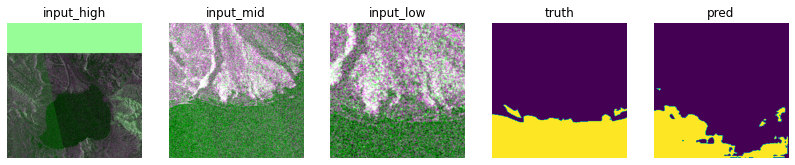

Ep41: Tra-> Loss:0.436,Oa:0.831,Miou:0.640, Val-> Loss:0.216,Oa:0.671,Miou:0.638,Time:11.9s
Ep42: Tra-> Loss:0.418,Oa:0.833,Miou:0.692, Val-> Loss:0.200,Oa:0.688,Miou:0.656,Time:11.6s
Ep43: Tra-> Loss:0.405,Oa:0.866,Miou:0.736, Val-> Loss:0.163,Oa:0.745,Miou:0.704,Time:11.4s
Ep44: Tra-> Loss:0.422,Oa:0.846,Miou:0.693, Val-> Loss:0.176,Oa:0.705,Miou:0.678,Time:11.7s
Ep45: Tra-> Loss:0.411,Oa:0.841,Miou:0.731, Val-> Loss:0.148,Oa:0.743,Miou:0.714,Time:11.7s
Ep46: Tra-> Loss:0.415,Oa:0.866,Miou:0.733, Val-> Loss:0.178,Oa:0.701,Miou:0.670,Time:11.6s
Ep47: Tra-> Loss:0.397,Oa:0.875,Miou:0.762, Val-> Loss:0.187,Oa:0.699,Miou:0.672,Time:11.7s
Ep48: Tra-> Loss:0.398,Oa:0.897,Miou:0.788, Val-> Loss:0.227,Oa:0.661,Miou:0.619,Time:11.6s
Ep49: Tra-> Loss:0.412,Oa:0.843,Miou:0.721, Val-> Loss:0.151,Oa:0.739,Miou:0.702,Time:11.2s
Ep50: Tra-> Loss:0.412,Oa:0.871,Miou:0.741, Val-> Loss:0.182,Oa:0.688,Miou:0.660,Time:11.5s


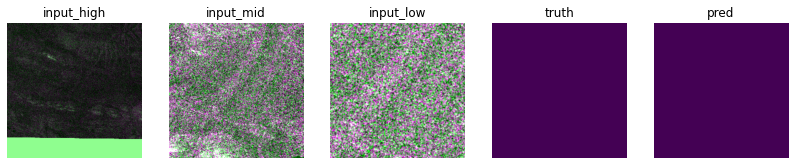

Ep51: Tra-> Loss:0.417,Oa:0.852,Miou:0.731, Val-> Loss:0.161,Oa:0.749,Miou:0.713,Time:11.8s
Ep52: Tra-> Loss:0.413,Oa:0.847,Miou:0.721, Val-> Loss:0.158,Oa:0.749,Miou:0.713,Time:11.7s
Ep53: Tra-> Loss:0.429,Oa:0.807,Miou:0.677, Val-> Loss:0.195,Oa:0.684,Miou:0.651,Time:11.7s
Ep54: Tra-> Loss:0.407,Oa:0.856,Miou:0.735, Val-> Loss:0.202,Oa:0.671,Miou:0.637,Time:11.4s
Ep55: Tra-> Loss:0.403,Oa:0.832,Miou:0.736, Val-> Loss:0.164,Oa:0.723,Miou:0.686,Time:11.2s
Ep56: Tra-> Loss:0.401,Oa:0.892,Miou:0.774, Val-> Loss:0.198,Oa:0.692,Miou:0.662,Time:11.7s
Ep57: Tra-> Loss:0.400,Oa:0.861,Miou:0.760, Val-> Loss:0.138,Oa:0.759,Miou:0.697,Time:11.3s
Ep58: Tra-> Loss:0.413,Oa:0.873,Miou:0.738, Val-> Loss:0.257,Oa:0.642,Miou:0.600,Time:11.7s
Ep59: Tra-> Loss:0.402,Oa:0.861,Miou:0.762, Val-> Loss:0.208,Oa:0.689,Miou:0.661,Time:11.6s
Ep60: Tra-> Loss:0.392,Oa:0.894,Miou:0.803, Val-> Loss:0.205,Oa:0.677,Miou:0.642,Time:12.1s


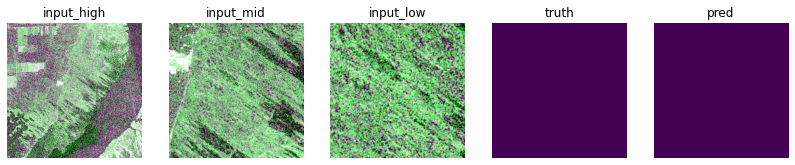

Ep61: Tra-> Loss:0.400,Oa:0.891,Miou:0.759, Val-> Loss:0.178,Oa:0.714,Miou:0.681,Time:11.5s
Ep62: Tra-> Loss:0.387,Oa:0.906,Miou:0.812, Val-> Loss:0.150,Oa:0.759,Miou:0.728,Time:11.5s
Ep63: Tra-> Loss:0.389,Oa:0.881,Miou:0.784, Val-> Loss:0.215,Oa:0.688,Miou:0.655,Time:11.7s
Ep64: Tra-> Loss:0.388,Oa:0.897,Miou:0.817, Val-> Loss:0.173,Oa:0.730,Miou:0.703,Time:11.7s
Ep65: Tra-> Loss:0.401,Oa:0.858,Miou:0.748, Val-> Loss:0.150,Oa:0.768,Miou:0.725,Time:11.7s
Ep66: Tra-> Loss:0.394,Oa:0.903,Miou:0.803, Val-> Loss:0.169,Oa:0.729,Miou:0.705,Time:12.0s
Ep67: Tra-> Loss:0.395,Oa:0.899,Miou:0.804, Val-> Loss:0.179,Oa:0.717,Miou:0.694,Time:11.4s
Ep68: Tra-> Loss:0.379,Oa:0.920,Miou:0.837, Val-> Loss:0.163,Oa:0.742,Miou:0.718,Time:12.1s
Ep69: Tra-> Loss:0.401,Oa:0.878,Miou:0.775, Val-> Loss:0.191,Oa:0.699,Miou:0.673,Time:12.0s
Ep70: Tra-> Loss:0.395,Oa:0.880,Miou:0.775, Val-> Loss:0.191,Oa:0.700,Miou:0.666,Time:11.6s


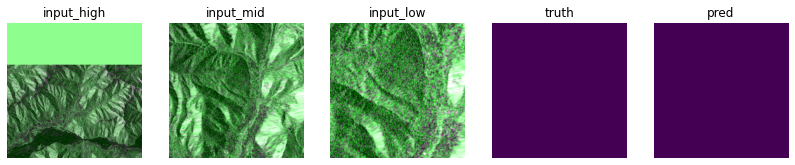

Ep71: Tra-> Loss:0.390,Oa:0.913,Miou:0.817, Val-> Loss:0.198,Oa:0.688,Miou:0.662,Time:11.4s
Ep72: Tra-> Loss:0.391,Oa:0.879,Miou:0.783, Val-> Loss:0.187,Oa:0.709,Miou:0.684,Time:11.5s
Ep73: Tra-> Loss:0.392,Oa:0.899,Miou:0.821, Val-> Loss:0.145,Oa:0.752,Miou:0.724,Time:11.6s
Ep74: Tra-> Loss:0.406,Oa:0.842,Miou:0.736, Val-> Loss:0.212,Oa:0.660,Miou:0.624,Time:11.7s
Ep75: Tra-> Loss:0.384,Oa:0.911,Miou:0.821, Val-> Loss:0.177,Oa:0.699,Miou:0.670,Time:11.9s
Ep76: Tra-> Loss:0.389,Oa:0.903,Miou:0.802, Val-> Loss:0.180,Oa:0.707,Miou:0.676,Time:11.4s
Ep77: Tra-> Loss:0.385,Oa:0.914,Miou:0.832, Val-> Loss:0.159,Oa:0.726,Miou:0.704,Time:11.9s
Ep78: Tra-> Loss:0.385,Oa:0.915,Miou:0.826, Val-> Loss:0.240,Oa:0.656,Miou:0.615,Time:11.8s
Ep79: Tra-> Loss:0.388,Oa:0.892,Miou:0.817, Val-> Loss:0.156,Oa:0.745,Miou:0.715,Time:11.6s
Ep80: Tra-> Loss:0.389,Oa:0.891,Miou:0.805, Val-> Loss:0.169,Oa:0.734,Miou:0.711,Time:11.7s


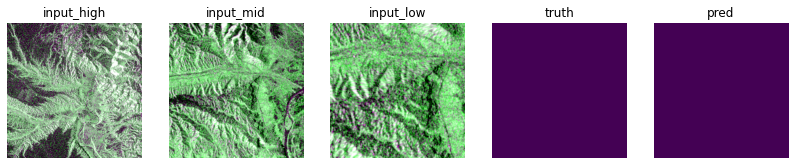

Ep81: Tra-> Loss:0.382,Oa:0.895,Miou:0.817, Val-> Loss:0.174,Oa:0.718,Miou:0.692,Time:11.5s
Ep82: Tra-> Loss:0.384,Oa:0.914,Miou:0.820, Val-> Loss:0.194,Oa:0.692,Miou:0.667,Time:11.6s
Ep83: Tra-> Loss:0.378,Oa:0.914,Miou:0.829, Val-> Loss:0.192,Oa:0.694,Miou:0.666,Time:11.5s
Ep84: Tra-> Loss:0.370,Oa:0.922,Miou:0.857, Val-> Loss:0.168,Oa:0.729,Miou:0.704,Time:11.8s
Ep85: Tra-> Loss:0.395,Oa:0.870,Miou:0.770, Val-> Loss:0.168,Oa:0.730,Miou:0.706,Time:11.8s
Ep86: Tra-> Loss:0.388,Oa:0.892,Miou:0.799, Val-> Loss:0.207,Oa:0.680,Miou:0.648,Time:11.5s
Ep87: Tra-> Loss:0.383,Oa:0.895,Miou:0.818, Val-> Loss:0.183,Oa:0.706,Miou:0.681,Time:11.6s
Ep88: Tra-> Loss:0.381,Oa:0.911,Miou:0.822, Val-> Loss:0.172,Oa:0.731,Miou:0.709,Time:11.8s
Ep89: Tra-> Loss:0.382,Oa:0.911,Miou:0.828, Val-> Loss:0.178,Oa:0.726,Miou:0.702,Time:11.8s
Ep90: Tra-> Loss:0.388,Oa:0.897,Miou:0.803, Val-> Loss:0.188,Oa:0.717,Miou:0.691,Time:11.9s


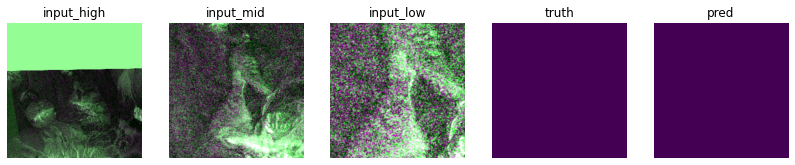

Ep91: Tra-> Loss:0.375,Oa:0.924,Miou:0.853, Val-> Loss:0.165,Oa:0.740,Miou:0.714,Time:11.5s
Ep92: Tra-> Loss:0.370,Oa:0.904,Miou:0.818, Val-> Loss:0.170,Oa:0.723,Miou:0.699,Time:11.4s
Ep93: Tra-> Loss:0.384,Oa:0.906,Miou:0.820, Val-> Loss:0.171,Oa:0.738,Miou:0.715,Time:11.7s
Ep94: Tra-> Loss:0.383,Oa:0.913,Miou:0.839, Val-> Loss:0.189,Oa:0.700,Miou:0.673,Time:11.2s
Ep95: Tra-> Loss:0.384,Oa:0.896,Miou:0.803, Val-> Loss:0.167,Oa:0.730,Miou:0.707,Time:11.9s
Ep96: Tra-> Loss:0.375,Oa:0.907,Miou:0.836, Val-> Loss:0.160,Oa:0.738,Miou:0.716,Time:11.8s
Ep97: Tra-> Loss:0.375,Oa:0.925,Miou:0.834, Val-> Loss:0.178,Oa:0.723,Miou:0.700,Time:11.7s
Ep98: Tra-> Loss:0.362,Oa:0.919,Miou:0.860, Val-> Loss:0.163,Oa:0.740,Miou:0.718,Time:11.7s
Ep99: Tra-> Loss:0.364,Oa:0.916,Miou:0.852, Val-> Loss:0.190,Oa:0.697,Miou:0.669,Time:11.5s
Ep100: Tra-> Loss:0.365,Oa:0.949,Miou:0.873, Val-> Loss:0.209,Oa:0.668,Miou:0.635,Time:11.5s


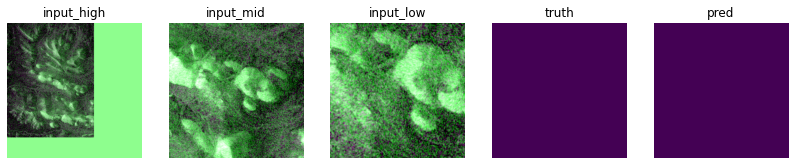

Ep101: Tra-> Loss:0.376,Oa:0.918,Miou:0.846, Val-> Loss:0.156,Oa:0.747,Miou:0.724,Time:12.0s
Ep102: Tra-> Loss:0.373,Oa:0.908,Miou:0.833, Val-> Loss:0.175,Oa:0.713,Miou:0.689,Time:11.8s
Ep103: Tra-> Loss:0.372,Oa:0.915,Miou:0.839, Val-> Loss:0.170,Oa:0.728,Miou:0.705,Time:12.1s
Ep104: Tra-> Loss:0.368,Oa:0.926,Miou:0.854, Val-> Loss:0.169,Oa:0.728,Miou:0.707,Time:11.7s
Ep105: Tra-> Loss:0.372,Oa:0.907,Miou:0.838, Val-> Loss:0.177,Oa:0.714,Miou:0.689,Time:11.3s
Ep106: Tra-> Loss:0.380,Oa:0.928,Miou:0.845, Val-> Loss:0.205,Oa:0.686,Miou:0.658,Time:11.8s
Ep107: Tra-> Loss:0.383,Oa:0.899,Miou:0.832, Val-> Loss:0.161,Oa:0.737,Miou:0.715,Time:11.4s
Ep108: Tra-> Loss:0.373,Oa:0.915,Miou:0.845, Val-> Loss:0.165,Oa:0.726,Miou:0.704,Time:11.4s
Ep109: Tra-> Loss:0.375,Oa:0.918,Miou:0.842, Val-> Loss:0.158,Oa:0.749,Miou:0.727,Time:11.4s
Ep110: Tra-> Loss:0.374,Oa:0.919,Miou:0.835, Val-> Loss:0.169,Oa:0.733,Miou:0.712,Time:11.6s


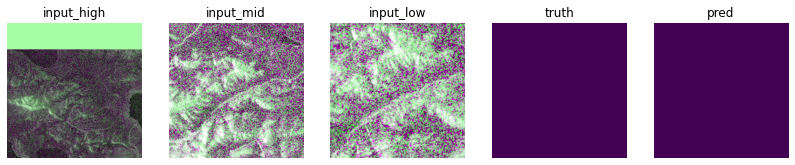

Ep111: Tra-> Loss:0.379,Oa:0.903,Miou:0.823, Val-> Loss:0.158,Oa:0.742,Miou:0.721,Time:11.9s
Ep112: Tra-> Loss:0.381,Oa:0.906,Miou:0.819, Val-> Loss:0.155,Oa:0.752,Miou:0.730,Time:11.5s
Ep113: Tra-> Loss:0.365,Oa:0.939,Miou:0.877, Val-> Loss:0.159,Oa:0.739,Miou:0.717,Time:11.6s
Ep114: Tra-> Loss:0.363,Oa:0.934,Miou:0.872, Val-> Loss:0.169,Oa:0.729,Miou:0.705,Time:11.5s
Ep115: Tra-> Loss:0.379,Oa:0.906,Miou:0.825, Val-> Loss:0.172,Oa:0.733,Miou:0.711,Time:11.3s
Ep116: Tra-> Loss:0.375,Oa:0.909,Miou:0.849, Val-> Loss:0.172,Oa:0.724,Miou:0.702,Time:11.5s
Ep117: Tra-> Loss:0.378,Oa:0.919,Miou:0.841, Val-> Loss:0.175,Oa:0.727,Miou:0.706,Time:11.8s
Ep118: Tra-> Loss:0.370,Oa:0.926,Miou:0.845, Val-> Loss:0.170,Oa:0.723,Miou:0.702,Time:11.5s
Ep119: Tra-> Loss:0.371,Oa:0.914,Miou:0.853, Val-> Loss:0.169,Oa:0.725,Miou:0.704,Time:11.5s
Ep120: Tra-> Loss:0.371,Oa:0.926,Miou:0.866, Val-> Loss:0.153,Oa:0.745,Miou:0.725,Time:11.9s


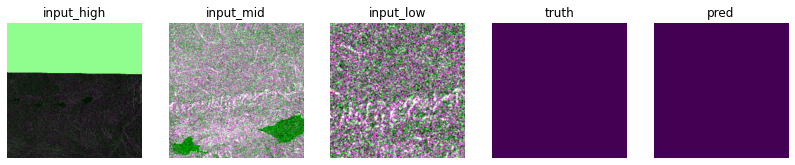

Ep121: Tra-> Loss:0.374,Oa:0.918,Miou:0.849, Val-> Loss:0.159,Oa:0.737,Miou:0.717,Time:11.8s
Ep122: Tra-> Loss:0.372,Oa:0.913,Miou:0.837, Val-> Loss:0.177,Oa:0.711,Miou:0.689,Time:11.6s
Ep123: Tra-> Loss:0.371,Oa:0.907,Miou:0.839, Val-> Loss:0.167,Oa:0.728,Miou:0.708,Time:11.2s
Ep124: Tra-> Loss:0.368,Oa:0.913,Miou:0.847, Val-> Loss:0.158,Oa:0.743,Miou:0.723,Time:11.3s
Ep125: Tra-> Loss:0.373,Oa:0.918,Miou:0.858, Val-> Loss:0.156,Oa:0.746,Miou:0.727,Time:11.9s
Ep126: Tra-> Loss:0.369,Oa:0.913,Miou:0.849, Val-> Loss:0.159,Oa:0.741,Miou:0.722,Time:11.7s
Ep127: Tra-> Loss:0.368,Oa:0.929,Miou:0.847, Val-> Loss:0.168,Oa:0.728,Miou:0.708,Time:11.7s
Ep128: Tra-> Loss:0.368,Oa:0.915,Miou:0.848, Val-> Loss:0.163,Oa:0.733,Miou:0.713,Time:11.6s
Ep129: Tra-> Loss:0.364,Oa:0.946,Miou:0.888, Val-> Loss:0.162,Oa:0.736,Miou:0.716,Time:11.6s
Ep130: Tra-> Loss:0.373,Oa:0.921,Miou:0.864, Val-> Loss:0.173,Oa:0.719,Miou:0.697,Time:11.7s


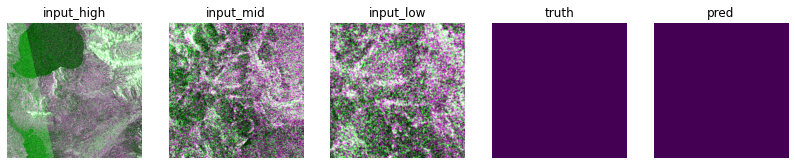

Ep131: Tra-> Loss:0.369,Oa:0.920,Miou:0.846, Val-> Loss:0.165,Oa:0.733,Miou:0.713,Time:11.5s
Ep132: Tra-> Loss:0.376,Oa:0.920,Miou:0.829, Val-> Loss:0.184,Oa:0.711,Miou:0.688,Time:11.7s
Ep133: Tra-> Loss:0.364,Oa:0.941,Miou:0.881, Val-> Loss:0.165,Oa:0.731,Miou:0.710,Time:11.6s
Ep134: Tra-> Loss:0.373,Oa:0.896,Miou:0.827, Val-> Loss:0.157,Oa:0.747,Miou:0.727,Time:11.1s
Ep135: Tra-> Loss:0.363,Oa:0.947,Miou:0.887, Val-> Loss:0.159,Oa:0.743,Miou:0.724,Time:11.4s
Ep136: Tra-> Loss:0.369,Oa:0.919,Miou:0.841, Val-> Loss:0.153,Oa:0.751,Miou:0.732,Time:11.5s
Ep137: Tra-> Loss:0.365,Oa:0.920,Miou:0.852, Val-> Loss:0.153,Oa:0.753,Miou:0.734,Time:12.0s
Ep138: Tra-> Loss:0.361,Oa:0.943,Miou:0.865, Val-> Loss:0.164,Oa:0.738,Miou:0.718,Time:11.5s
Ep139: Tra-> Loss:0.357,Oa:0.940,Miou:0.881, Val-> Loss:0.164,Oa:0.736,Miou:0.716,Time:11.7s
Ep140: Tra-> Loss:0.363,Oa:0.919,Miou:0.856, Val-> Loss:0.148,Oa:0.758,Miou:0.738,Time:11.6s


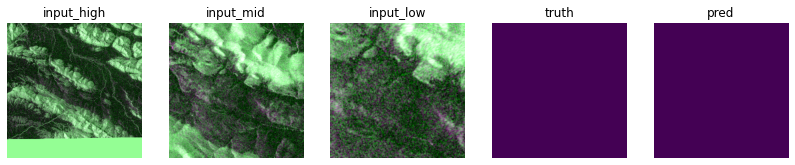

Ep141: Tra-> Loss:0.366,Oa:0.937,Miou:0.851, Val-> Loss:0.161,Oa:0.740,Miou:0.721,Time:11.5s
Ep142: Tra-> Loss:0.359,Oa:0.925,Miou:0.858, Val-> Loss:0.150,Oa:0.752,Miou:0.734,Time:11.5s
Ep143: Tra-> Loss:0.367,Oa:0.918,Miou:0.843, Val-> Loss:0.165,Oa:0.738,Miou:0.718,Time:11.6s
Ep144: Tra-> Loss:0.366,Oa:0.928,Miou:0.854, Val-> Loss:0.157,Oa:0.748,Miou:0.729,Time:11.9s
Ep145: Tra-> Loss:0.361,Oa:0.923,Miou:0.864, Val-> Loss:0.149,Oa:0.758,Miou:0.739,Time:11.6s
Ep146: Tra-> Loss:0.364,Oa:0.945,Miou:0.877, Val-> Loss:0.162,Oa:0.740,Miou:0.720,Time:12.2s
Ep147: Tra-> Loss:0.368,Oa:0.927,Miou:0.857, Val-> Loss:0.161,Oa:0.744,Miou:0.725,Time:11.9s
Ep148: Tra-> Loss:0.371,Oa:0.906,Miou:0.843, Val-> Loss:0.152,Oa:0.756,Miou:0.738,Time:11.5s
Ep149: Tra-> Loss:0.360,Oa:0.927,Miou:0.855, Val-> Loss:0.150,Oa:0.757,Miou:0.738,Time:11.7s
Ep150: Tra-> Loss:0.362,Oa:0.934,Miou:0.853, Val-> Loss:0.164,Oa:0.737,Miou:0.717,Time:11.5s


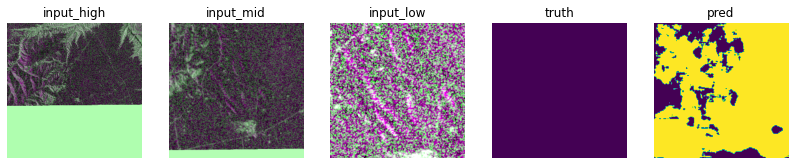

Ep151: Tra-> Loss:0.378,Oa:0.895,Miou:0.808, Val-> Loss:0.153,Oa:0.754,Miou:0.735,Time:11.6s
Ep152: Tra-> Loss:0.377,Oa:0.920,Miou:0.841, Val-> Loss:0.162,Oa:0.744,Miou:0.724,Time:11.6s
Ep153: Tra-> Loss:0.368,Oa:0.927,Miou:0.859, Val-> Loss:0.160,Oa:0.744,Miou:0.724,Time:11.2s
Ep154: Tra-> Loss:0.362,Oa:0.940,Miou:0.870, Val-> Loss:0.165,Oa:0.737,Miou:0.716,Time:11.7s
Ep155: Tra-> Loss:0.366,Oa:0.941,Miou:0.874, Val-> Loss:0.172,Oa:0.729,Miou:0.707,Time:11.3s
Ep156: Tra-> Loss:0.364,Oa:0.934,Miou:0.870, Val-> Loss:0.155,Oa:0.751,Miou:0.731,Time:11.9s
Ep157: Tra-> Loss:0.360,Oa:0.952,Miou:0.898, Val-> Loss:0.156,Oa:0.748,Miou:0.728,Time:11.3s
Ep158: Tra-> Loss:0.363,Oa:0.942,Miou:0.859, Val-> Loss:0.162,Oa:0.745,Miou:0.725,Time:11.3s
Ep159: Tra-> Loss:0.363,Oa:0.925,Miou:0.847, Val-> Loss:0.162,Oa:0.748,Miou:0.728,Time:12.0s
Ep160: Tra-> Loss:0.360,Oa:0.942,Miou:0.881, Val-> Loss:0.150,Oa:0.761,Miou:0.742,Time:11.6s


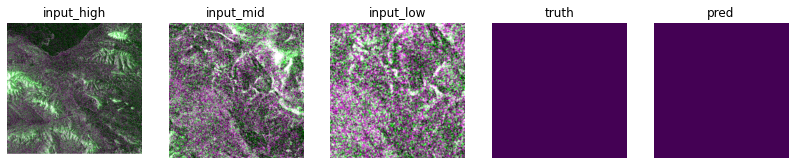

Ep161: Tra-> Loss:0.361,Oa:0.946,Miou:0.884, Val-> Loss:0.158,Oa:0.752,Miou:0.732,Time:11.3s
Ep162: Tra-> Loss:0.379,Oa:0.904,Miou:0.811, Val-> Loss:0.163,Oa:0.746,Miou:0.726,Time:11.5s
Ep163: Tra-> Loss:0.369,Oa:0.926,Miou:0.861, Val-> Loss:0.161,Oa:0.747,Miou:0.727,Time:11.6s
Ep164: Tra-> Loss:0.367,Oa:0.916,Miou:0.847, Val-> Loss:0.153,Oa:0.757,Miou:0.738,Time:11.4s
Ep165: Tra-> Loss:0.371,Oa:0.929,Miou:0.847, Val-> Loss:0.158,Oa:0.752,Miou:0.732,Time:11.5s
Ep166: Tra-> Loss:0.378,Oa:0.913,Miou:0.830, Val-> Loss:0.159,Oa:0.750,Miou:0.731,Time:11.4s
Ep167: Tra-> Loss:0.364,Oa:0.934,Miou:0.852, Val-> Loss:0.161,Oa:0.747,Miou:0.728,Time:11.6s
Ep168: Tra-> Loss:0.362,Oa:0.930,Miou:0.868, Val-> Loss:0.166,Oa:0.739,Miou:0.719,Time:11.5s
Ep169: Tra-> Loss:0.365,Oa:0.924,Miou:0.867, Val-> Loss:0.167,Oa:0.737,Miou:0.716,Time:11.3s
Ep170: Tra-> Loss:0.369,Oa:0.918,Miou:0.859, Val-> Loss:0.161,Oa:0.744,Miou:0.724,Time:11.5s


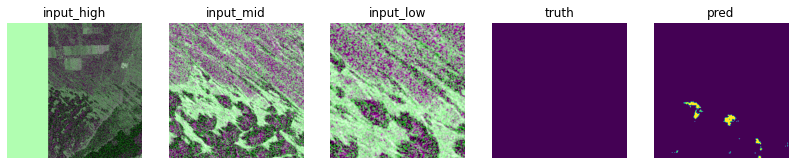

Ep171: Tra-> Loss:0.368,Oa:0.913,Miou:0.841, Val-> Loss:0.162,Oa:0.744,Miou:0.724,Time:11.7s
Ep172: Tra-> Loss:0.372,Oa:0.884,Miou:0.809, Val-> Loss:0.165,Oa:0.741,Miou:0.721,Time:11.7s


In [11]:
metrics = train_loops(model=model,  
                    loss_fn=config.loss_bce,  
                    optimizer=optimizer,  
                    tra_loader=tra_loader,  
                    val_loader=val_loader,  
                    epoches=config.epoch,  
                    lr_scheduler=lr_scheduler)


## Model and metrics saving


In [ ]:
# model_name = 'gscales_des_test_7'
# # model_name = 'model_gscales_test_12'
# # model save/load
# path_weights = config.root_proj + '/model/pretrained/gscales_des_test/' + model_name + '_weights.pth'
# # path_weights = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name + '_weights.pth'
# # torch.save(model.state_dict(), path_weights)
# model.load_state_dict(torch.load(path_weights))



In [ ]:
# ## metrics saving
# path_metrics = config.root_proj + '/model/pretrained/gscales_des_test/' + model_name + '_metrics.csv'
# # path_metrics = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')
# metrics_df = pd.read_csv(path_metrics)
